# ABS Monthly Labour Force - 6202

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-set-up" data-toc-modified-id="Python-set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python set-up</a></span></li><li><span><a href="#Python-environment" data-toc-modified-id="Python-environment-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Python environment</a></span></li><li><span><a href="#Get-data-from-ABS" data-toc-modified-id="Get-data-from-ABS-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Get data from ABS</a></span></li><li><span><a href="#Plot" data-toc-modified-id="Plot-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Plot</a></span><ul class="toc-item"><li><span><a href="#Common-plotting-functions" data-toc-modified-id="Common-plotting-functions-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Common plotting functions</a></span></li><li><span><a href="#Headline-charts" data-toc-modified-id="Headline-charts-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Headline charts</a></span></li><li><span><a href="#State-comparisons" data-toc-modified-id="State-comparisons-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>State comparisons</a></span></li><li><span><a href="#Gendered-comparisons" data-toc-modified-id="Gendered-comparisons-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Gendered comparisons</a></span></li></ul></li><li><span><a href="#Finished" data-toc-modified-id="Finished-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Finished</a></span></li></ul></div>

## Python set-up

In [1]:
# system imports
import sys
import platform
import psutil
from pathlib import Path
from datetime import date
import requests
import hashlib
import zipfile
import io

# analytic imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# pandas display settings
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

# plotting stuff
plt.style.use('ggplot')

In [2]:
# cache directory
CACHE = '../cache'
Path(CACHE).mkdir(parents=True, exist_ok=True)

# charts directory
CHART_DIRECTORY = '../charts'
Path(CHART_DIRECTORY).mkdir(parents=True, exist_ok=True)

## Python environment

In [3]:
N = 50
print('-'*N)
print(f"System:         {platform.system()}")
print(f"Release:        {platform.release()}")
#print(f"Version:        {platform.version()}")
print(f"Machine:        {platform.machine()}")
print(f"Processor:      {platform.processor()}")
print(f"RAM:            {round(psutil.virtual_memory().total / 1024**3)}GB")
print('-'*N)
print(f"Python:         {platform.python_version()}")
print(f"Psutil:         {psutil.__version__}")
print(f"Pandas:         {pd.__version__}")
print(f"Numpy:          {np.__version__}")
print(f"Matplotlib:     {mpl.__version__}")
print('-'*N)

--------------------------------------------------
System:         Darwin
Release:        20.1.0
Machine:        x86_64
Processor:      i386
RAM:            64GB
--------------------------------------------------
Python:         3.8.3
Psutil:         5.7.0
Pandas:         1.0.5
Numpy:          1.18.5
Matplotlib:     3.2.2
--------------------------------------------------


## Get data from ABS

In [4]:
def previous_month(month, year):
    """Find the previous (month, year) combination 
        for a given (month, year) combination
       Arguments:
       - month - integer between 1 and 12
       - year - integer
       Returns:
       - Tuple (month, year) - same form as arguments
    """
    
    month = month - 1
    if month == 0:
        month = 12
        year -= 1
    return month, year

In [5]:
def download_and_cache(URL, CACHE):
    """If the URL has not been cached, download it and cache it:
       Arguments:
       - URL - string - url for file
       - CACHE - string - directory name where cached file is placed
       Returns:
       - None - if URL does not exist
       - a bytes array of the cached zip file of excel spreadsheets
    """

    code = requests.head(URL).status_code
    if code == 200:
        # if the URL exists, see if we have previously downloaded and cached.
        # if not previously downloaded, we will doenload now and cache.
        cache = (f'{CACHE}/{hashlib.sha384(URL.encode()).hexdigest()}.cache')
        if (file := Path(cache)).is_file():
            print('File has been cached already')
            zip_file = file.read_bytes()
        else:
            print('We need to cache this file')
            zip_file = requests.get(URL, allow_redirects=True).content # bytes
            file.open(mode='w', buffering=-1, encoding=None, errors=None, newline=None)
            file.write_bytes(zip_file)

        # return success
        return zip_file # as a bytes buffer
    
    # return failure
    return None

In [6]:
def get_ABS_zip_file(url_template):
    """Using an url_template, get the ABS zipped file as a bytes array
       Arguments:
       - url_template - string - with MONTH-YEAR as a token that will be 
                                 substituted with a series of months/years
                                 walking backwards from the current to get 
                                 the most recent data.
       Returns:
       - a bytes array of the cached zip file of excel spreadsheets
    """

    # function constants
    MAX_TRIES = 15 # maximum number of previous months to try
    MONTHS = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 
              'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    
    # we will start with the previous month and work backwards
    # assume ABS data is at least one month old. 
    month, year = previous_month(date.today().month, date.today().year)
    for count in range(MAX_TRIES+1):
    
        # exit with error if the counter has gone too far backwards
        if count >= MAX_TRIES:
            sys.exit('Could not find and download the URL')
        
        # let's see if the URL exists
        month_year = MONTHS[month - 1] + '-' + str(year)
        URL = url_template.replace('MONTH-YEAR', month_year)
        if (zip_file := download_and_cache(URL, CACHE)) is not None:
            print(f'File for {month_year} of ' +
                  f'size {np.round((len(zip_file) / 1024**2), 1)} MB')
            break
        
        # let's try a month earlier
        month, year = previous_month(month, year)
    
    # if we are here, then we have a cached file we can unzip
    return zip_file

In [7]:
# let's build a single dataframe for all the data we have collected
def get_dataframes(zip_file, warning=False):
    """Get the dataframe for zipfile of excel spreadsheets
        Arguments:
        - zip_file - bytes array of ABS zip file of excel spreadsheets
        Returns:
        - tuple (meta, data), where
            - meta - is a pandas DataFrame of metadata
            - data - is a pandas DataFrame of the actual data"""
    
    zipped = zipfile.ZipFile(io.BytesIO(zip_file))
    zipped_elements = zipped.infolist()

    meta = pd.DataFrame()
    data = pd.DataFrame()
    for ze in zipped_elements:
    
        # get the zipfile into pandas
        zfile = zipped.read(ze.filename)
        xl = pd.ExcelFile(zfile)

        # get table information
        sheet_meta = xl.parse('Index', nrows=8)
        table = sheet_meta.iat[4,1]
        splat = table.split('.')
        tab_num = splat[0].split(' ')[-1].strip()
        tab_desc = '.'.join(splat[1:]).strip()
        #print(tab_num, tab_desc) 
        
        # get the metadata
        sheet_meta = xl.parse('Index', header=9, parse_dates=True, 
                              infer_datetime_format=True,)
        sheet_meta = sheet_meta.iloc[1:-2] # drop first and last 2
        sheet_meta = sheet_meta.dropna(axis='columns', how='all')
        sheet_meta['Table'] = tab_num.strip()
        sheet_meta['Table Description'] = tab_desc
        meta = meta.append(sheet_meta, ignore_index=True)
    
        # get the actual data
        data_sheets = [x for x in xl.sheet_names if x.startswith('Data')]
        for sheet_name in data_sheets:
            sheet_data = xl.parse(sheet_name, header=9, index_col=0, 
                                  parse_dates=True, infer_datetime_format=True,)
        
            for i in sheet_data.columns:
                if i in data.columns:
                    # Remove duplicate Series IDs before merging
                    del sheet_data[i]
                    continue
                if warning and sheet_data[i].isna().all():
                    # Warn if data series is all NA
                    problematic = meta.loc[meta["Series ID"] == i][
                        ['Table', 'Data Item Description', 'Series Type']]
                    print(f'Warning: no data for {i}\n{problematic}\n\n')

            # merge data into a large dataframe
            if len(data) == 0:
                data = sheet_data
            else:
                data = pd.merge(left=data, right=sheet_data, how='outer',
                                left_index=True, right_index=True, suffixes=('', ''))
    
    return meta, data

In [8]:
# do the data capture and extraction to a DataFrame
url_template = ('https://www.abs.gov.au/statistics/labour/'
                'employment-and-unemployment/labour-force-australia/'
                'MONTH-YEAR/6202_all%20spreadsheet.zip')

zip_file = get_ABS_zip_file(url_template)
meta, data = get_dataframes(zip_file)

File has been cached already
File for oct-2020 of size 41.7 MB


## Plot

### Common plotting functions

In [9]:
def finalise_plot(ax, title, ylabel):
    """Function to finalise plots
        Arguments:
        - ax - matplotlib axes object
        - title - string - plot title, also used to save the file
        - ylabel - string - ylabel
        Returns: 
        - None
    """
    
    # annotate plot
    ax.set_title(title)
    ax.set_xlabel(None)
    ax.set_ylabel(ylabel)
    
    # fix margins - I should not need to do this!
    FACTOR = 0.015
    xlim = ax.get_xlim()
    adjustment = (xlim[1] - xlim[0]) * FACTOR
    ax.set_xlim([xlim[0] - adjustment, xlim[1] + adjustment])
    
    # finalise
    fig = ax.figure
    fig.set_size_inches(8, 4)
    fig.tight_layout(pad=1.2)
        
    # acknowledge sourse
    fig.text(0.99, 0.01, 
            'Source: ABS 6202',
            ha='right', va='bottom',
            fontsize=9, fontstyle='italic',
            color='#999999')

    # save and close
    title = title.replace(":", "-")
    fig.savefig(f'{CHART_DIRECTORY}/{title}.png', dpi=125)
    plt.show()
    plt.close()
    
    return None

In [10]:
def get_identifier(meta, data_item_description, series_type, table):
    """Get the ABS series identifier that matches the given 
       data_item_description, series_type, table
       Arguments:
        - meta - pandas DataFrame of metadata from the ABS
        - data_item_description - string
        - series_type - string - typically one of "Original"
                                 "Seasonally Adjusted" or "Trend"
        - table - string - ABS Table number - eg. '1' or '19a'
       Returns:
        - Tuple (id, units), where:
            - id - string - identifier for an ABS data series (column name)
            - units - string - unit of measurement
    """
    
    # make selection
    selected = meta[
        (meta['Data Item Description'] == data_item_description) &
        (meta['Series Type'] == series_type) &
        (meta['Table'] == table)
    ]
    
    # check
    if len(selected) != 1:
        print(f'Warning: {len(selected)} items selected in get_identifier()')
        
    # return results
    id = selected['Series ID'].iloc[0]
    units = selected['Unit'].iloc[0]
    return id, units
    

### Headline charts

Note: with COVID, the ABS has stopped publishing the Trend series.  

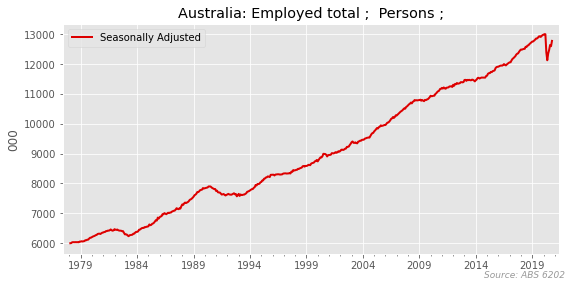

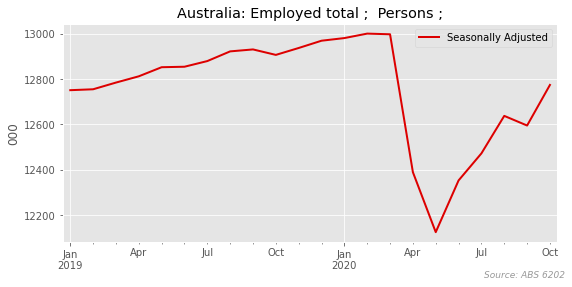

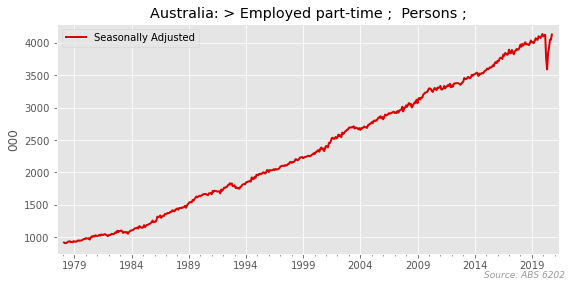

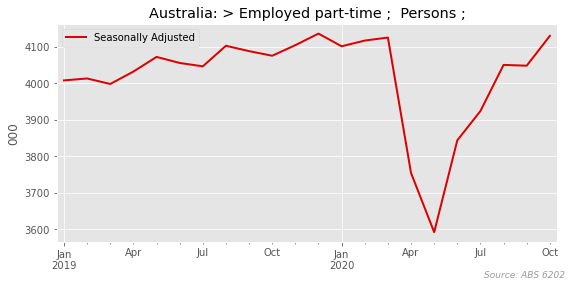

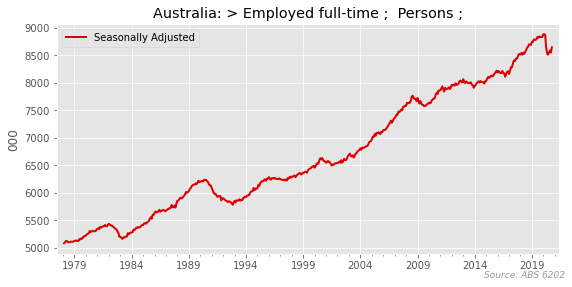

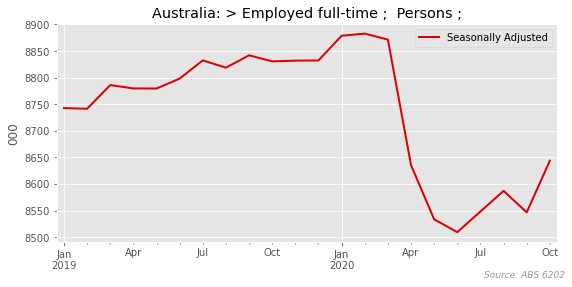

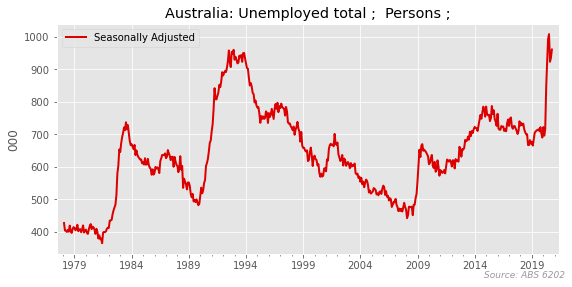

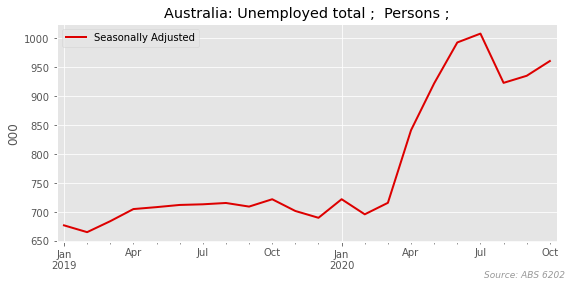

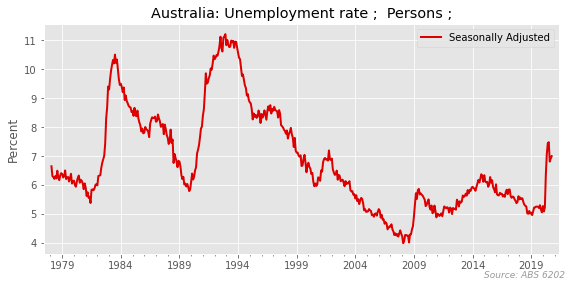

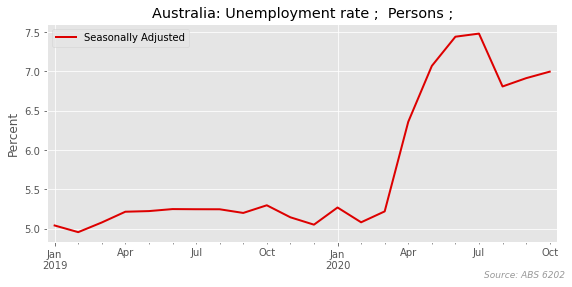

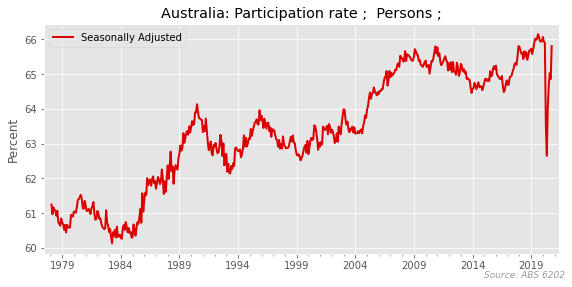

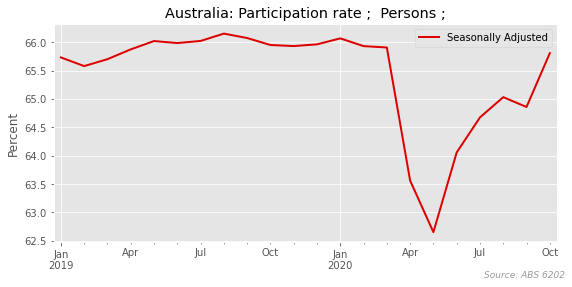

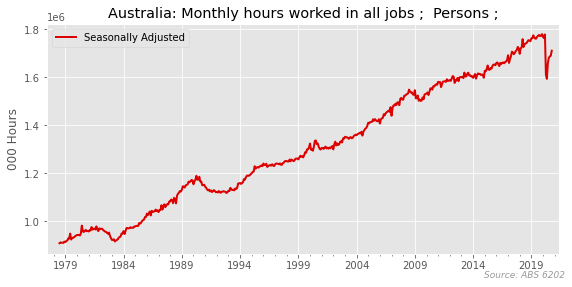

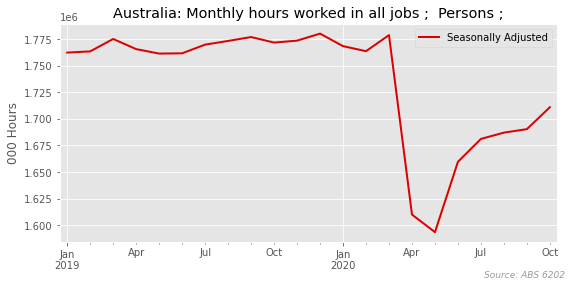

In [11]:
headlines = {
    # data item                                       # table number
    'Employed total ;  Persons ;':                    '1',
    '> Employed part-time ;  Persons ;':              '1',
    '> Employed full-time ;  Persons ;':              '1',
    'Unemployed total ;  Persons ;':                  '1',
    'Unemployment rate ;  Persons ;':                 '1', 
    'Participation rate ;  Persons ;':                '1',
    'Monthly hours worked in all jobs ;  Persons ;':  '19',
}
frames = (data, data[data.index >= pd.Timestamp('2019-01-01')])
tags = ('full', 'recent')

for headline, table in headlines.items():
    for df, tag in zip(frames, tags):

        # get meta data
        seasadj, units = get_identifier(meta, headline, 
                                        "Seasonally Adjusted", 
                                        table)
        
        # plot actual data 
        ax = df[[seasadj]].plot(c='#dd0000', lw=2)
    
        # annotate plot
        ax.legend(['Seasonally Adjusted'], loc='best')
        title = f'Australia: {headline}'
        finalise_plot(ax, title, units)

### State comparisons 

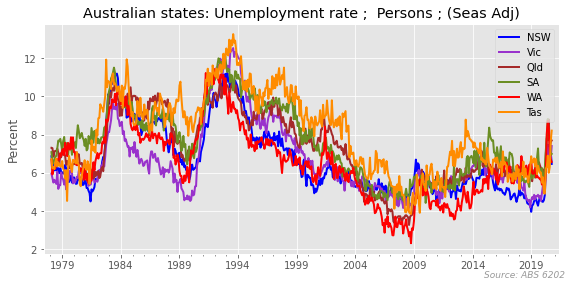

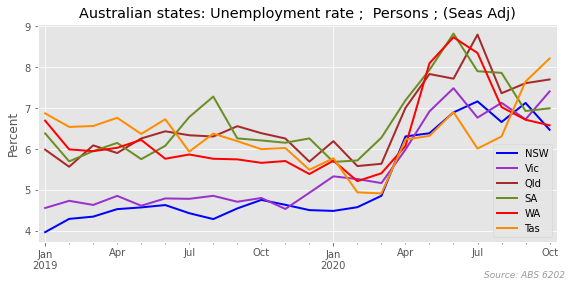

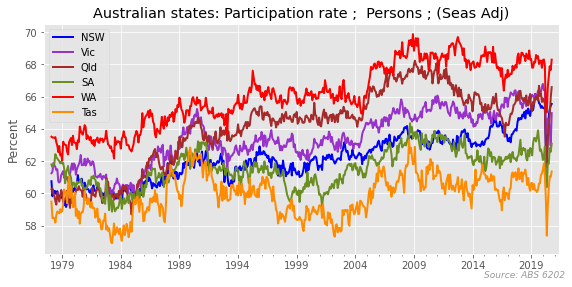

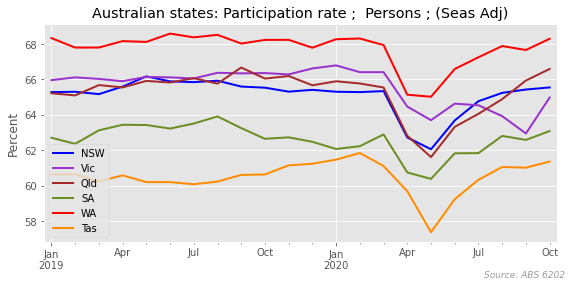

In [12]:
states = {
    # state                     # table
    "NSW":                      '4',
    "Vic":                      '5',
    "Qld":                      "6",
    "SA":                       "7",
    "WA":                       "8",
    "Tas":                      "9",
}

plots = [
    'Unemployment rate ;  Persons ;', 
    'Participation rate ;  Persons ;',
]

colours = ['blue', 'darkorchid', 'brown', 'olivedrab', 'red', 
           'darkorange', 'darkgoldenrod', 'teal',]

frames = (data, data[data.index >= pd.Timestamp('2019-01-01')])
tags = ('full', 'recent')

for plot in plots:
    collection = []
    for state, table in states.items():
        id, units = get_identifier(meta, plot, "Seasonally Adjusted", table)
        collection.append(id)
        
    for frame, tag in zip(frames, tags):
        ax = frame[collection].plot(lw=2, color=colours)

        # annotate plot
        ax.legend(states.keys(), loc='best')
        title = f'Australian states: {plot} (Seas Adj)'
        finalise_plot(ax, title, units)

### Gendered comparisons

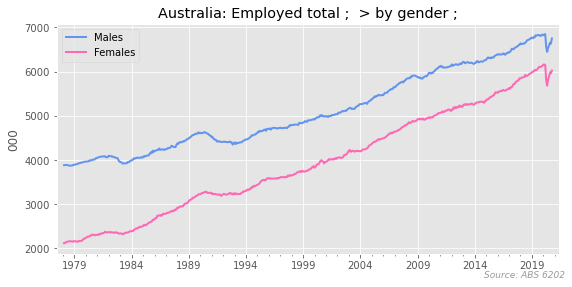

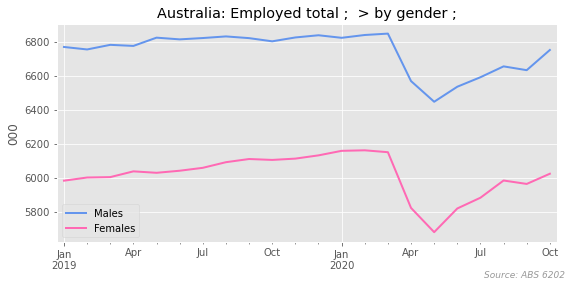

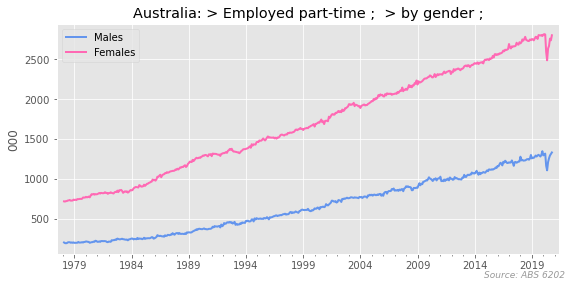

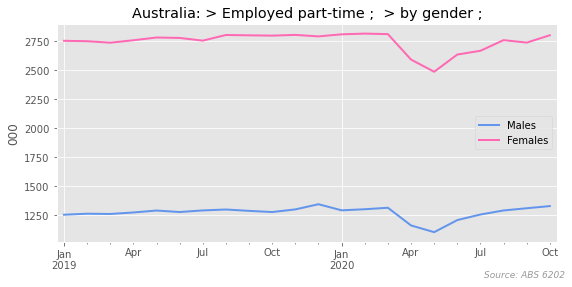

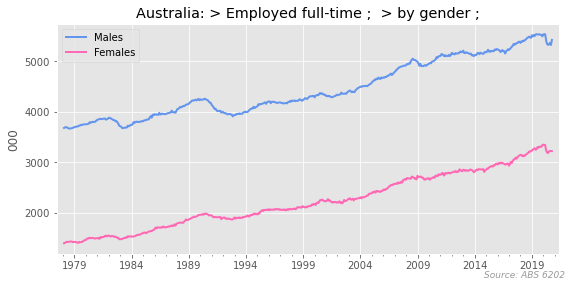

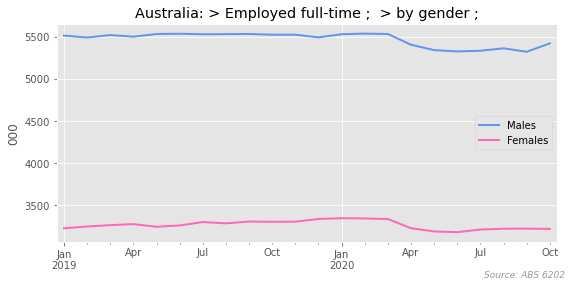

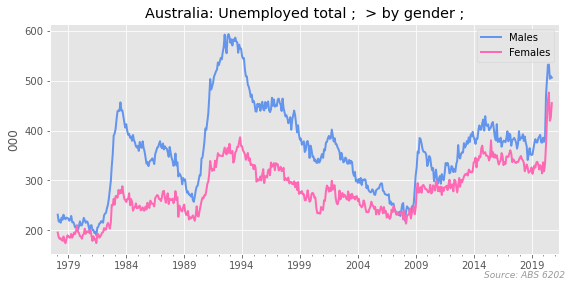

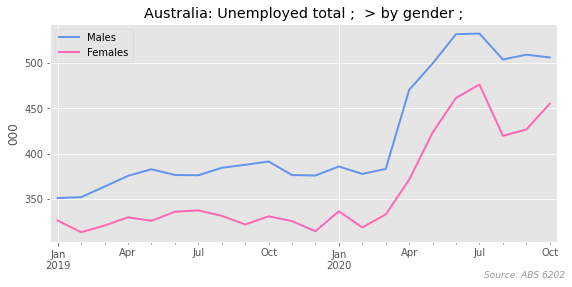

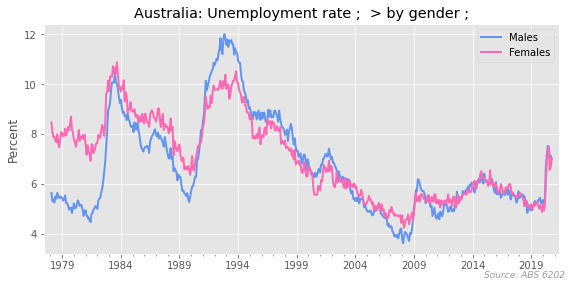

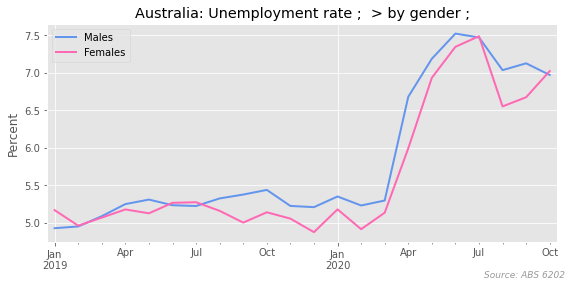

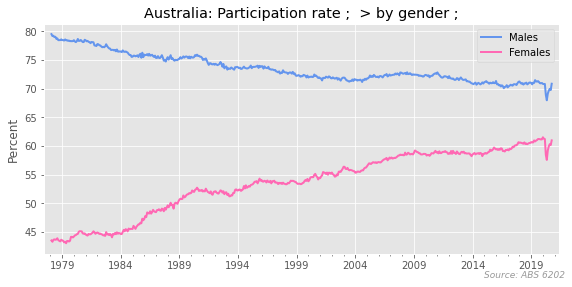

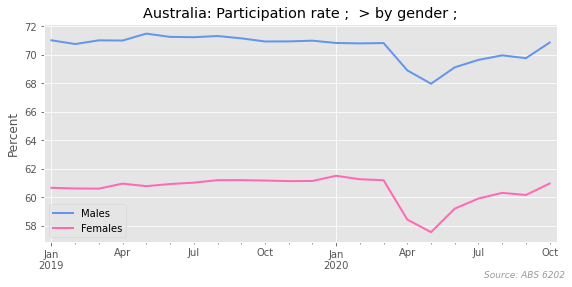

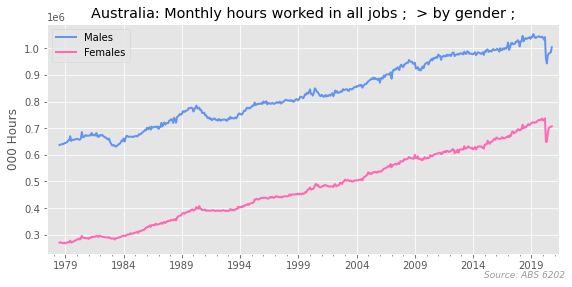

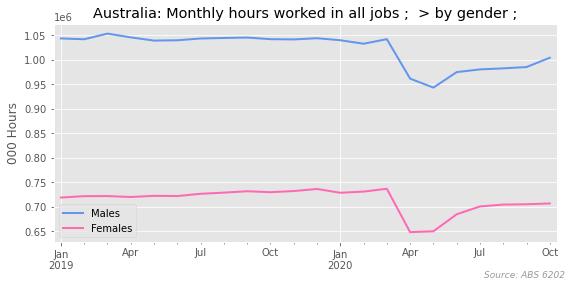

In [18]:
genders = ['Males', 'Females']
colours = ['cornflowerblue', 'hotpink']
token = 'by gender' # note: also appears in plot title
plots = {
    # data description                       # table
    f'Employed total ;  > {token} ;':       '1',
    f'> Employed part-time ;  > {token} ;': '1',
    f'> Employed full-time ;  > {token} ;': '1',
    f'Unemployed total ;  > {token} ;':     '1',
    f"Unemployment rate ;  > {token} ;":    '1',
    f"Participation rate ;  > {token} ;":   '1',
    f'Monthly hours worked in all jobs ;  > {token} ;':  '19',
}

frames = (data, data[data.index >= pd.Timestamp('2019-01-01')])
tags = ('full', 'recent')

for plot, table in plots.items():
    collection = []
    
    for gender in genders:
        this_gender = plot.replace(token, gender)
        id, units = get_identifier(meta, this_gender, 
                                   "Seasonally Adjusted", 
                                   table)
        collection.append(id)

    for frame, tag in zip(frames, tags):
        ax = frame[collection].plot(lw=2, color=colours)

        # annotate plot
        ax.legend(genders, loc='best')
        title = f"Australia: {plot}"
        finalise_plot(ax, title, units)  

## Finished

In [14]:
print('Finished')

Finished
